In [9]:
#Librerie utili
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from scipy import stats 
import scipy.stats as st

In [4]:
con = sqlite3.connect("../code/omnet/simulations/results/simulate.sca")

In [71]:
def confIntervalT99(data_series):
    """
    Calculate the confidence interval for the data distribution under the assumptions that it can be calculated using \
    a student-t distribution.
    """

    mean = np.mean(data_series)

    conf_int = st.sem(data_series) * st.t.ppf((1 + 0.99) / 2, len(data_series) - 1)

    #start = mean - conf_int
    #end = mean + conf_int

    return conf_int

# Confidence Interval Analysis

In [72]:
#THROUGHPUT

dfThroughput=pd.read_sql_query("""
select scenario, config, clients, attrValue, statCount / 3600.0 as throughput
from runConfig rc inner join statistic s on rc.runId = s.runId
        inner join runAttr ra on s.runId = ra.runId
where statName = "completedTransactions:stats"
 AND attrName = "repetition"
order by scenario, config, clients, attrValue
""", con)

#Getting all the configurations in the simulation table (column config)
#configurations=dfThroughput['config'].unique()
configurations=['c1','c3','c5','c8']

#Getting all the scenarios in the simulation table (column config)
scenarios=dfThroughput['scenario'].unique()

#Adding column for mean of the sample and the confidence interval
dfThroughput['throughput_mean'] = dfThroughput.groupby(['scenario','config','clients'])['throughput'].transform('mean')
dfThroughput['throughput_ci'] = dfThroughput.groupby(['scenario','config','clients'])['throughput'].transform(confIntervalT99)

#Delete Duplicate rows (we're not interest in all the repetition)
dfThroughput=dfThroughput.loc[(dfThroughput['attrValue']== '0')]
dfThroughput=dfThroughput.drop(['attrValue'],axis=1)

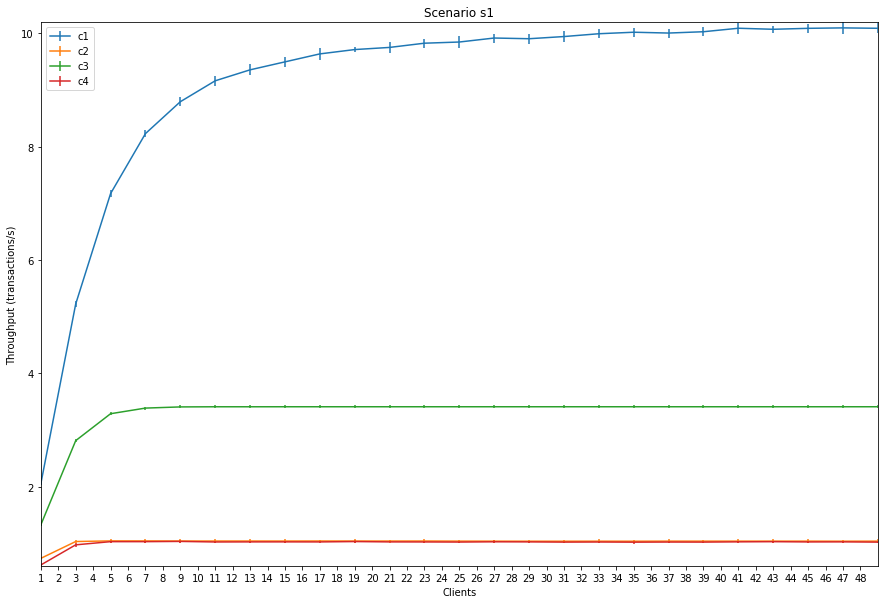

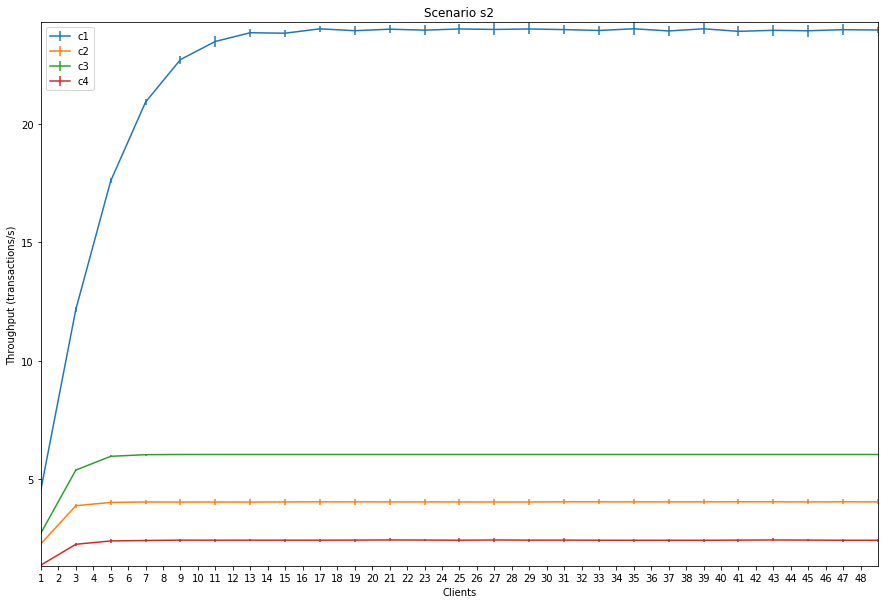

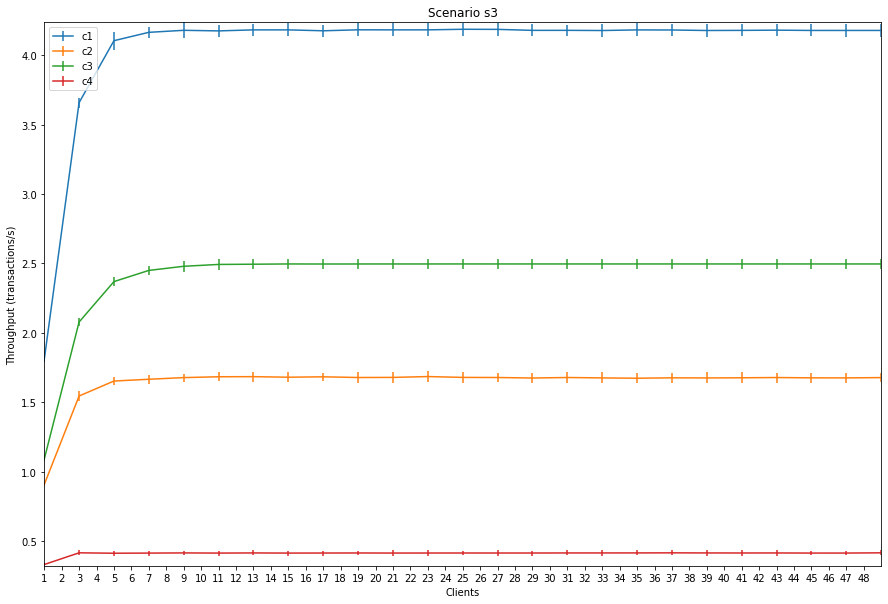

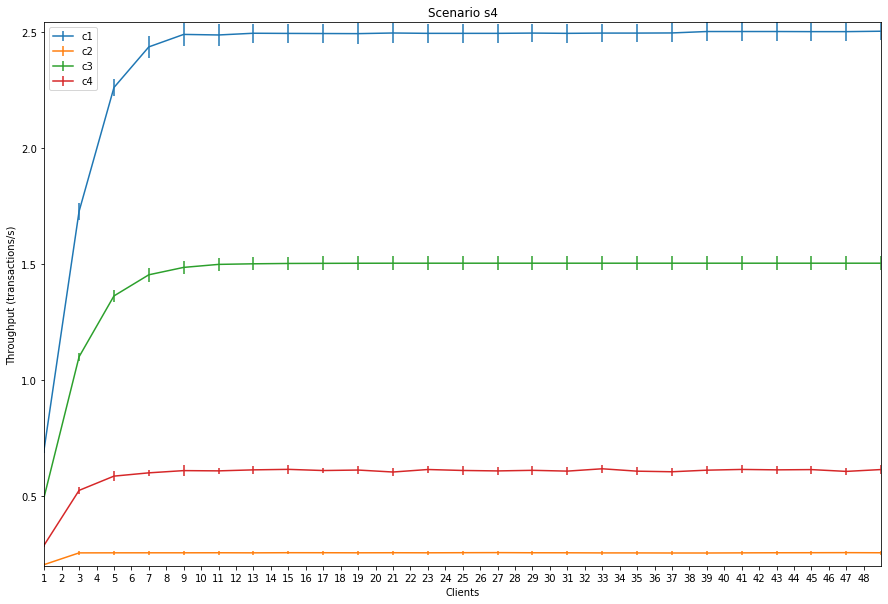

In [73]:
#FOR EVERY SCENARIO AND EVERY CONFIGURATIONS SHOW HOW CHANGE THE THROUGHPUT TIME WITH DIFFERENT NUMBER OF CLIENTS

for scenario in scenarios:
    plt.figure(figsize=(15,10))
    plt.title("Scenario "+scenario)
    plt.margins(0)
    plt.xticks(range(dfThroughput['clients'].min(),dfThroughput['clients'].max()))
    markers=["-o","^","+","d","h",]
    for index,conf in enumerate(configurations):
        dfTemp=dfThroughput.loc[(dfThroughput['scenario']== scenario) & (dfThroughput['config'] == conf)]
        plt.errorbar(dfTemp['clients'], dfTemp['throughput_mean'],yerr=dfTemp['throughput_ci'])
    
        
    #LABELLING THE PLOT
    plt.xlabel('Clients') 
    plt.ylabel('Throughput (transactions/s)')
    #plt.legend(configurations)
    plt.legend(['c1','c2','c3','c4'])
    plt.show()



In [74]:
#RENSPONSE TIME

#QUERY DB
dfResponseTime=pd.read_sql_query("""
SELECT clients, scenario, config,attrValue,statMean as responseTime 
from runConfig rc inner join statistic s on rc.runId = s.runId
        inner join runAttr ra on s.runId = ra.runId
WHERE 
		statName = "responseTimeStat:stats" AND
		moduleName = "Network"
        AND attrName = "repetition"
ORDER BY scenario, config, clients, attrValue
""", con)

#Adding column for mean of the sample and the confidence interval
dfResponseTime['responseTime_mean'] = dfResponseTime.groupby(['scenario','config','clients'])['responseTime'].transform('mean')
dfResponseTime['responseTime_ci'] = dfResponseTime.groupby(['scenario','config','clients'])['responseTime'].transform(confIntervalT99)

dfResponseTime.head()

#dfResponseTime=dfResponseTime.loc[(dfResponseTime['attrValue']== '0')]
#dfResponseTime.drop(['attrValue'],axis=1)


,clients,scenario,config,attrValue,responseTime,responseTime_mean,responseTime_ci
0,1,s1,c1,0,0.480001,0.487371,0.00579
1,1,s1,c1,1,0.496964,0.487371,0.00579
2,1,s1,c1,2,0.486095,0.487371,0.00579
3,1,s1,c1,3,0.481619,0.487371,0.00579
4,1,s1,c1,4,0.489958,0.487371,0.00579


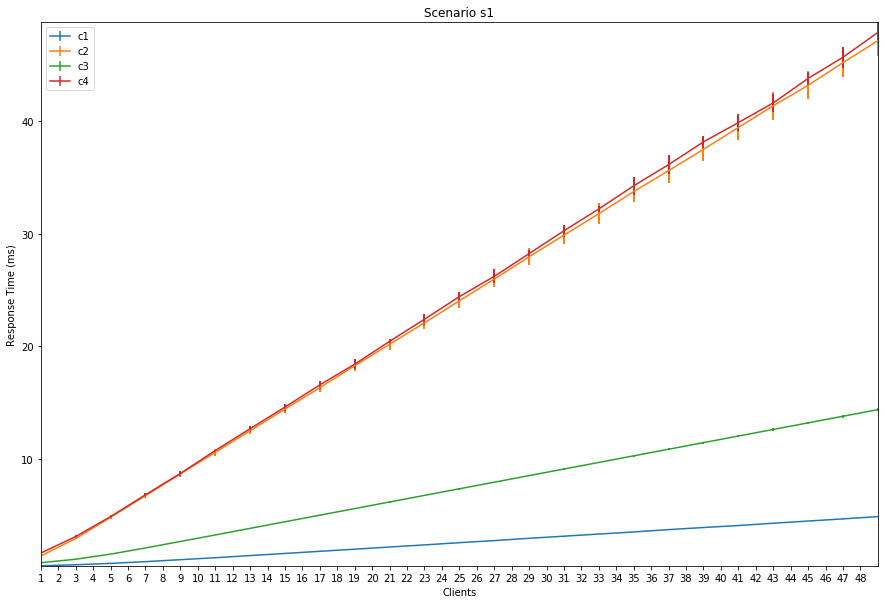

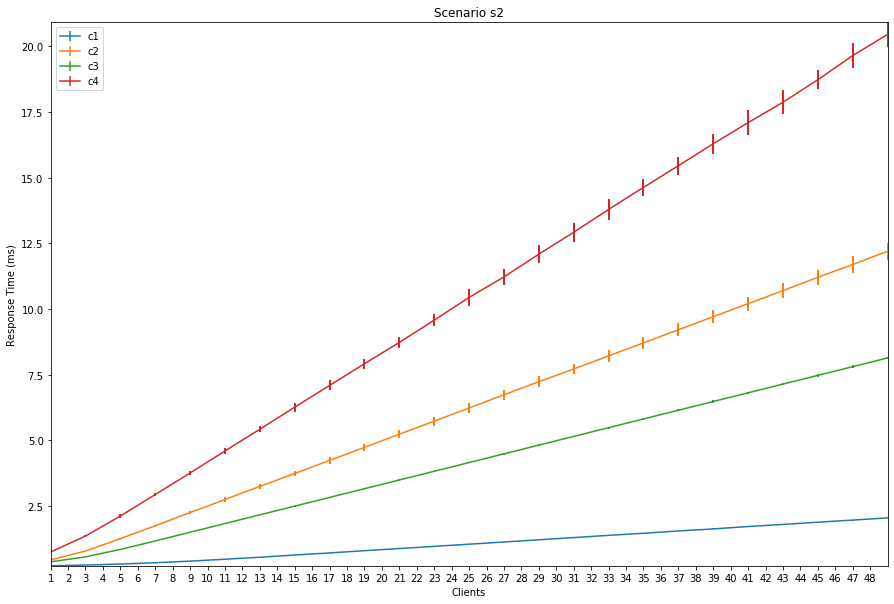

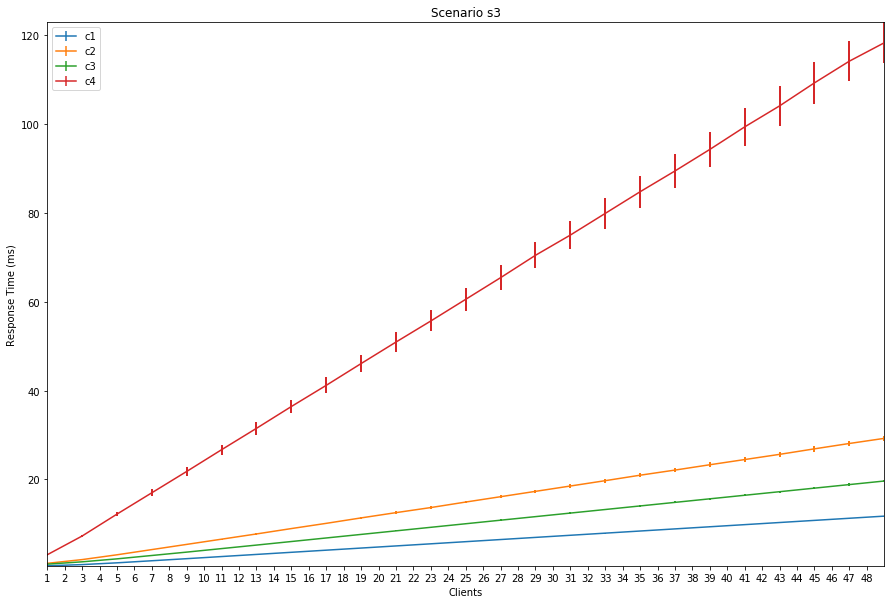

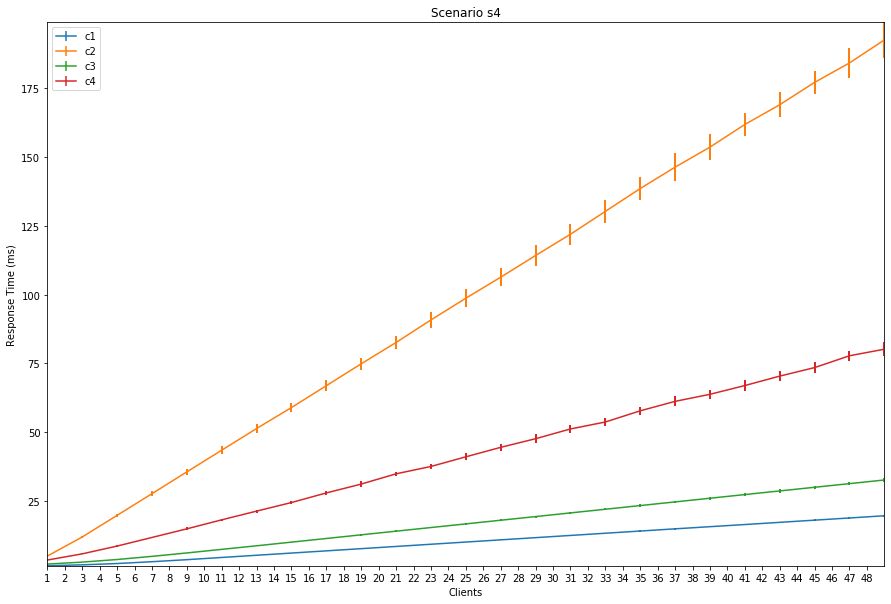

In [12]:
#FOR EVERY SCENARIO AND EVERY CONFIGURATIONS SHOW HOW CHANGE THE RESPONSE TIME WITH DIFFERENT NUMBER OF CLIENTS
for scenario in scenarios:
    plt.figure(figsize=(15,10))
    plt.title("Scenario "+scenario)
    plt.margins(0)
    plt.xticks(range(dfResponseTime['clients'].min(),dfResponseTime['clients'].max()))
    for conf in configurations:
        dfTemp=dfResponseTime.loc[(dfResponseTime['scenario']== scenario) & (dfResponseTime['config'] == conf)]
        plt.errorbar(dfTemp['clients'], dfTemp['responseTime_mean'],yerr=dfTemp['responseTime_ci'])
    
    #LABELLING THE PLOT
    
    plt.xlabel('Clients') 
    plt.ylabel('Response Time (ms)')
    #plt.legend(configurations)
    plt.legend(['c1','c2','c3','c4'])
    plt.show()




In [67]:
#COMPONENTS UTILIZATION GROUPED BY SCENARIOS WITH FINAL CONFIGURATIONS

#QUERY DB
dfUtilization=pd.read_sql_query("""
SELECT clients, scenario, config, moduleName,attrValue, statSum/4800 as utilization 
from runConfig rc inner join statistic s on rc.runId = s.runId
        inner join runAttr ra on s.runId = ra.runId
WHERE
		statName = "workingStat:stats"
        AND attrName = "repetition"
        AND clients=49
ORDER BY scenario,config,clients,moduleName
""", con)


#Prendo solo le configurazioni rilevanti

dfUtilization=dfUtilization.loc[(dfUtilization.config=="c1") | (dfUtilization.config=="c3")|(dfUtilization.config=="c5")|(dfUtilization.config=="c8")]

#Rimappo i nomi nel dataframe con un dizionario
configDictionary={"c1": "c1","c3": "c2","c5": "c3","c8": "c4"}
dfUtilization["config"]=dfUtilization["config"].map(configDictionary)


#Adding column for mean of the sample and the confidence interval
dfUtilization['utilization_ci'] = dfUtilization.groupby(['scenario','config','clients','moduleName'])['utilization'].transform(confIntervalT99)

#Delete duplicates
dfUtilization=dfUtilization.loc[(dfUtilization['attrValue']== '0')]
dfUtilization=dfUtilization.drop(['attrValue'],axis=1)

#Set here number of clients 
clientsNum=49

dfUtilization.head()

,clients,scenario,config,moduleName,utilization,utilization_ci
0,49,s1,c1,Network.remote_server,0.751466,0.028053
10,49,s1,c1,Network.server.disk,0.831330,0.028382
20,49,s1,c1,Network.server.processor,0.222598,0.001030
66,49,s1,c2,Network.remote_server,0.999957,0.000008
76,49,s1,c2,Network.server.disk,0.076984,0.003153


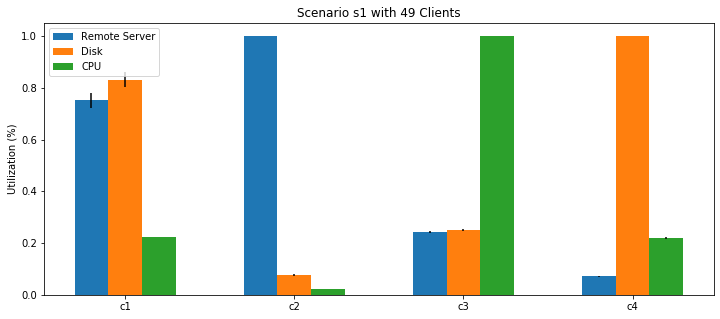

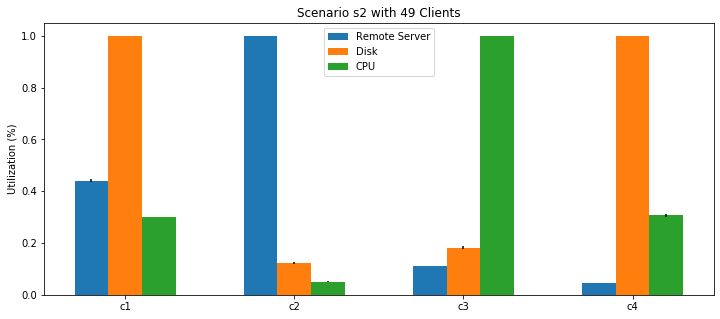

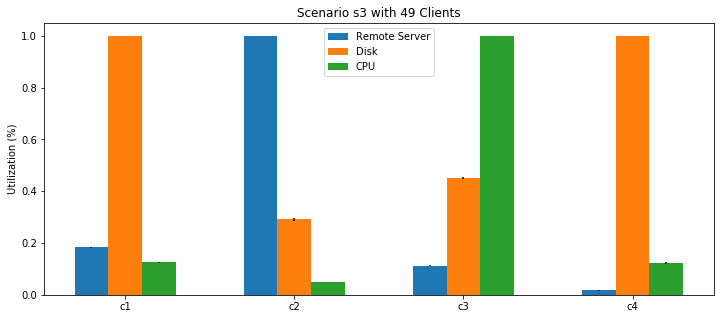

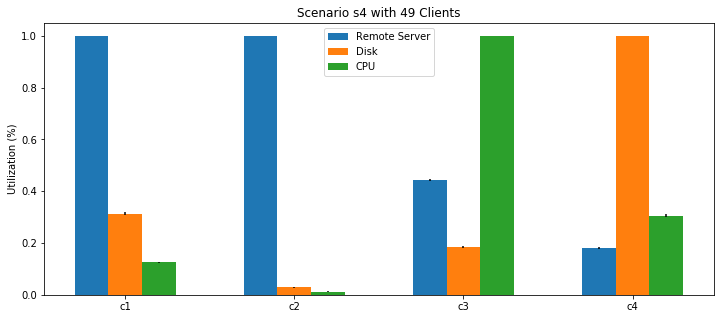

In [68]:
#For every configurations plot a graph of utilization of the components by every scenario

for scenario in scenarios:
    
    labels = ['c1', 'c2', 'c3','c4']
    remoteServerUtilization,remoteServerCI = [],[]
    diskUtilization,diskUtilizationCI = [],[]
    cpuUtilization, cpuUtilizationCI = [],[]                          

    x = np.arange(len(labels))  # the label locations
    width = 0.20  # the width of the bars

    
    dfTemp=dfUtilization.loc[(dfUtilization['scenario']== scenario)]
    dfTemp.sort_values(by=['moduleName'])

    remoteServerUtilization=list(dfTemp.loc[(dfTemp['moduleName']=='Network.remote_server')]['utilization'])
    remoteServerCI=list(dfTemp.loc[(dfTemp['moduleName']=='Network.remote_server')]['utilization_ci'])
    diskUtilization=list(dfTemp.loc[(dfTemp['moduleName']=='Network.server.disk')]['utilization'])
    diskUtilizationCI=list(dfTemp.loc[(dfTemp['moduleName']=='Network.server.disk')]['utilization_ci'])
    cpuUtilization=list(dfTemp.loc[(dfTemp['moduleName']=='Network.server.processor')]['utilization'])
    cpuUtilizationCI=list(dfTemp.loc[(dfTemp['moduleName']=='Network.server.processor')]['utilization_ci'])                   
                          
    

    fig, ax = plt.subplots(figsize=(12,5))
    rects1 = ax.bar(x -width, remoteServerUtilization, width, label='Remote Server',yerr=remoteServerCI)
    rects2 = ax.bar(x , diskUtilization, width, label='Disk',yerr=diskUtilizationCI)
    rects3 = ax.bar(x + width, cpuUtilization, width, label='CPU',yerr=cpuUtilizationCI)


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Utilization (%)')
    ax.set_title('Scenario '+scenario+' with 49 Clients')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()                          
                 
                                           
                              

# Normal Testing

# Throughput

In [37]:
#THROUGHPUT

dfThroughput=pd.read_sql_query("""
select scenario, config, clients, attrValue, statCount / 3600.0 as throughput
from runConfig rc inner join statistic s on rc.runId = s.runId
        inner join runAttr ra on s.runId = ra.runId
where statName = "completedTransactions:stats"
 AND attrName = "repetition"
order by scenario, config, clients, attrValue
""", con)

#Getting all the configurations in the simulation table (column config)
#configurations=dfThroughput['config'].unique()
configurations=['c1','c3','c5','c8']

#Getting all the scenarios in the simulation table (column config)
scenarios=dfThroughput['scenario'].unique()



dfThroughput.head(15)

,scenario,config,clients,attrValue,throughput
0,s1,c1,1,0,2.083333
1,s1,c1,1,1,2.012222
2,s1,c1,1,2,2.058056
3,s1,c1,1,3,2.076389
4,s1,c1,1,4,2.040833
5,s1,c1,1,5,2.018056
6,s1,c1,1,6,2.058611
7,s1,c1,1,7,2.058333
8,s1,c1,1,8,2.072778
9,s1,c1,1,9,2.043889


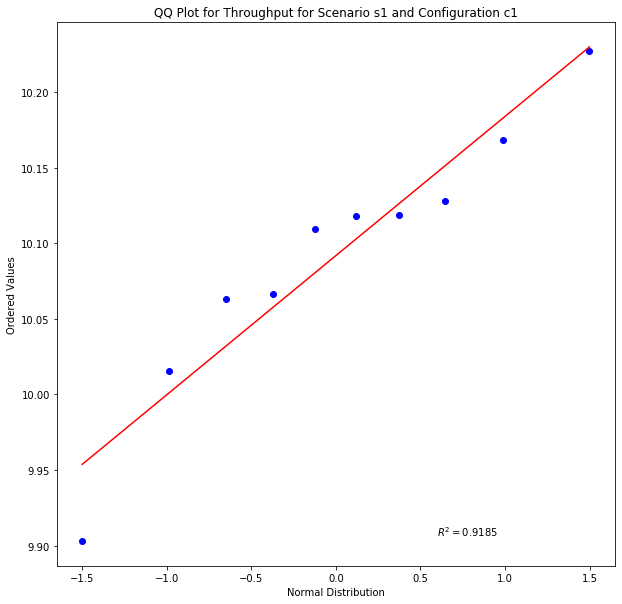

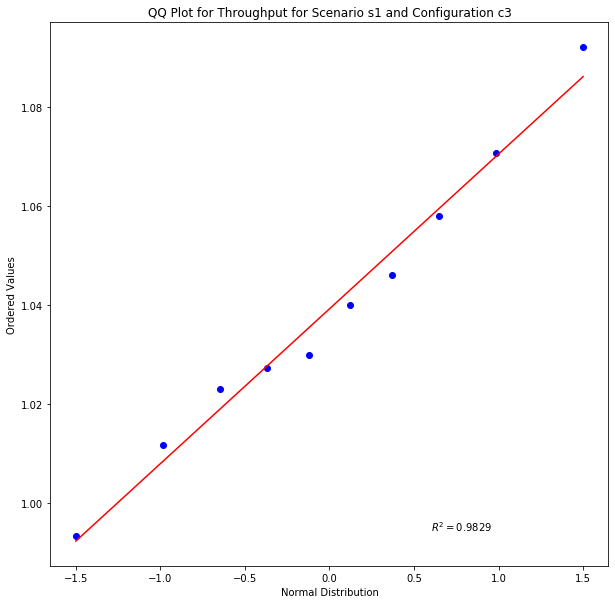

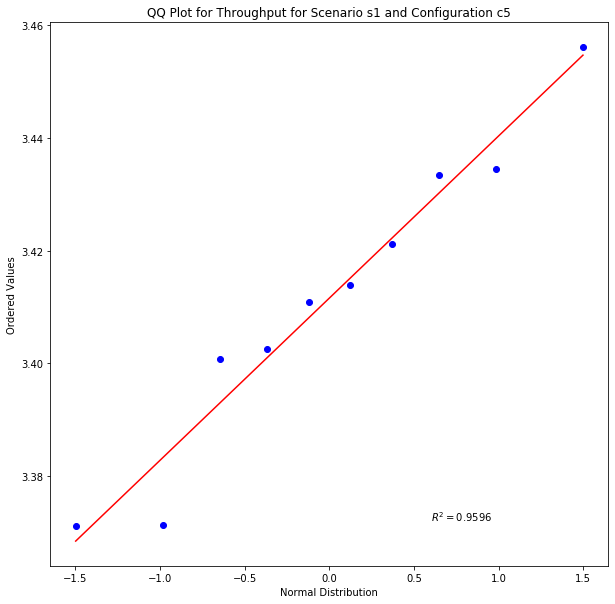

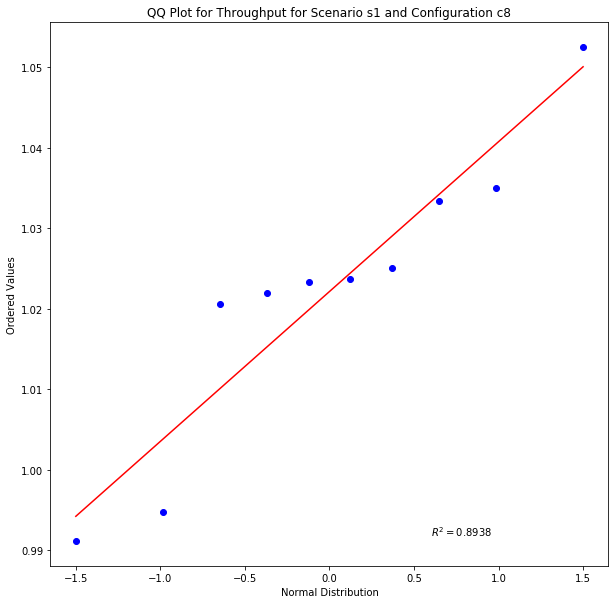

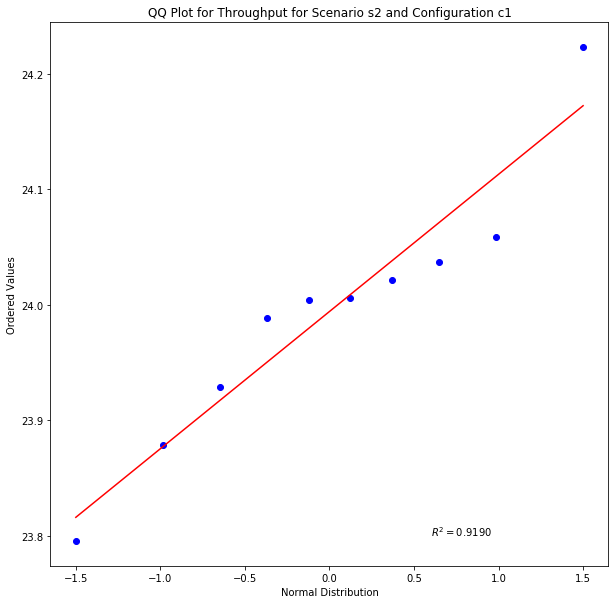

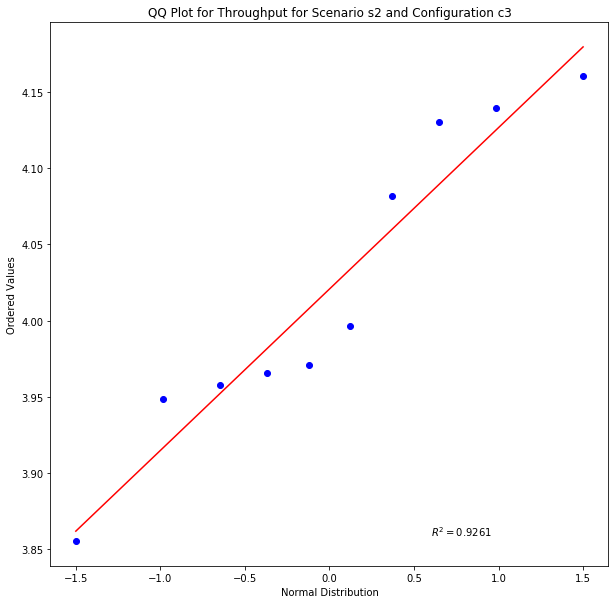

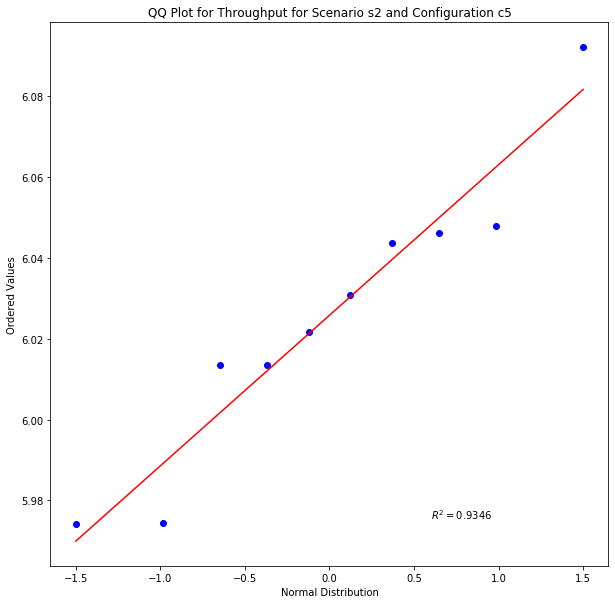

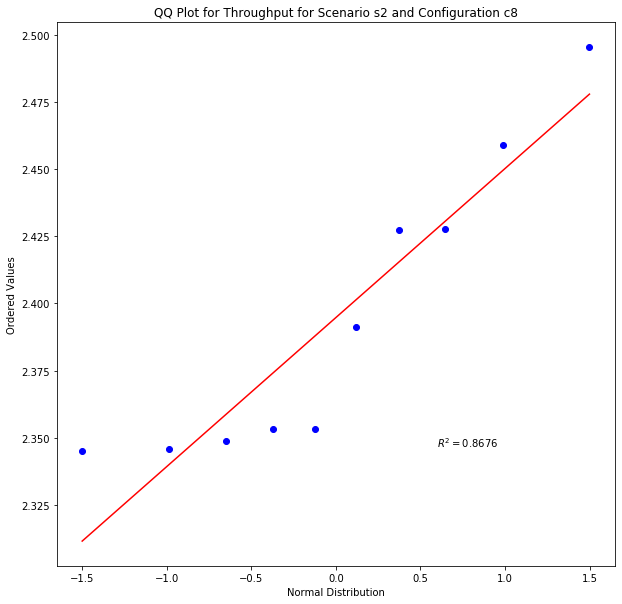

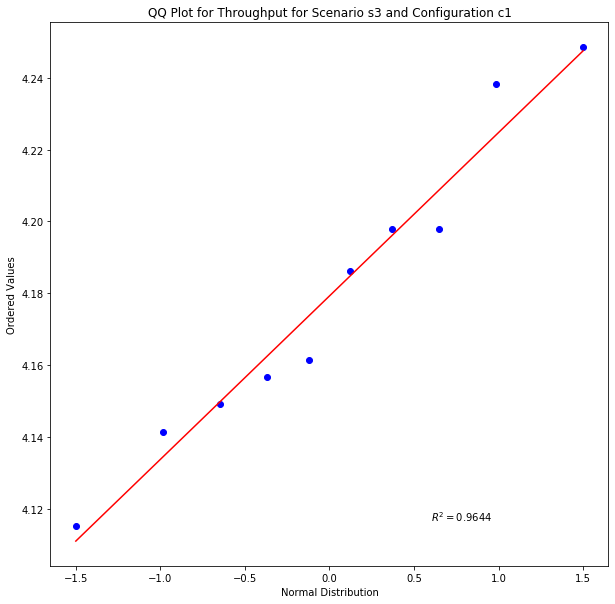

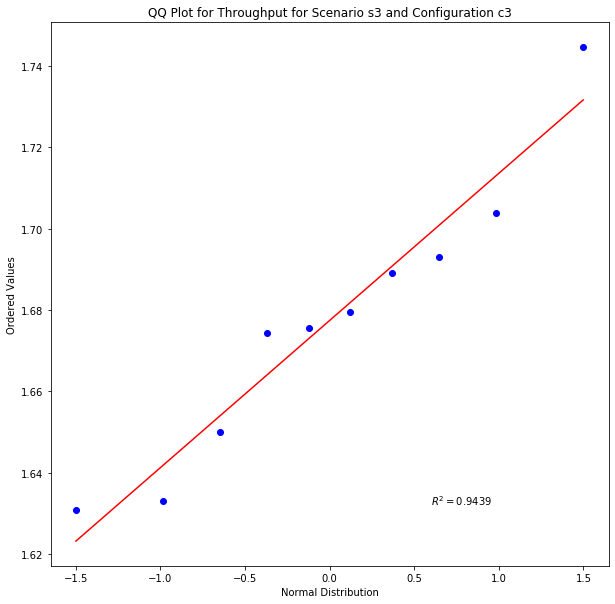

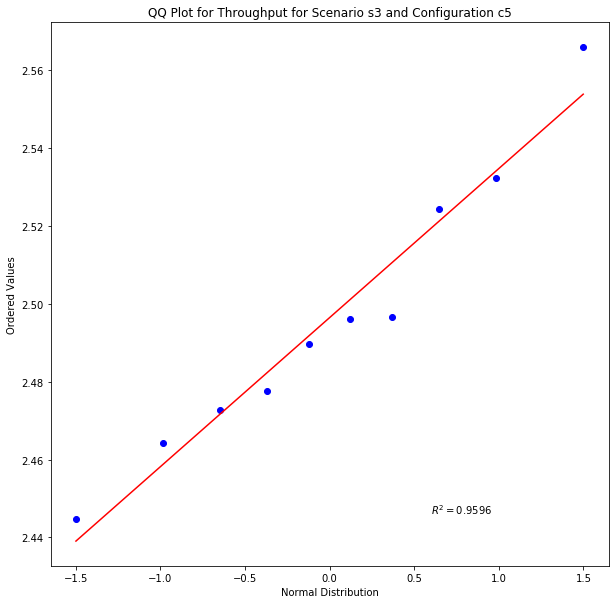

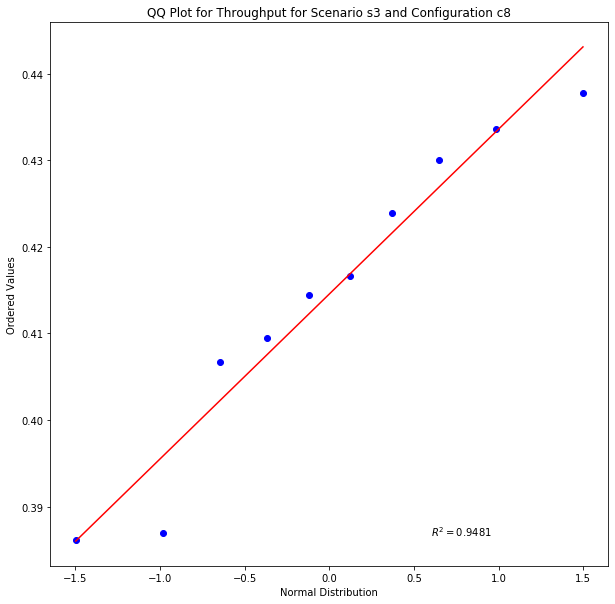

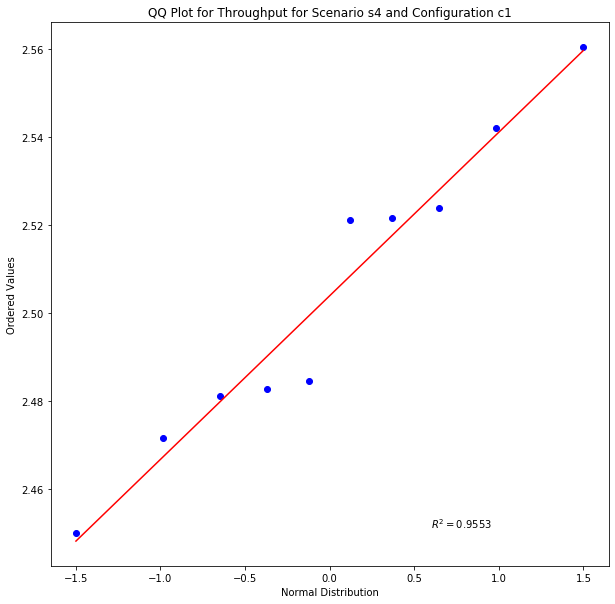

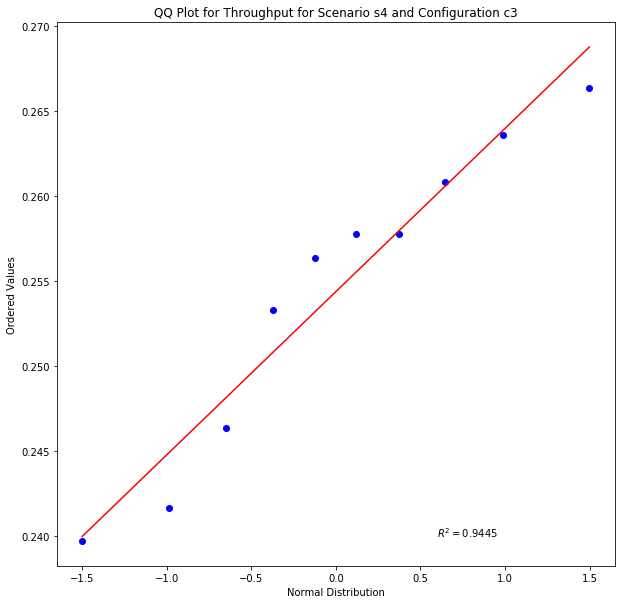

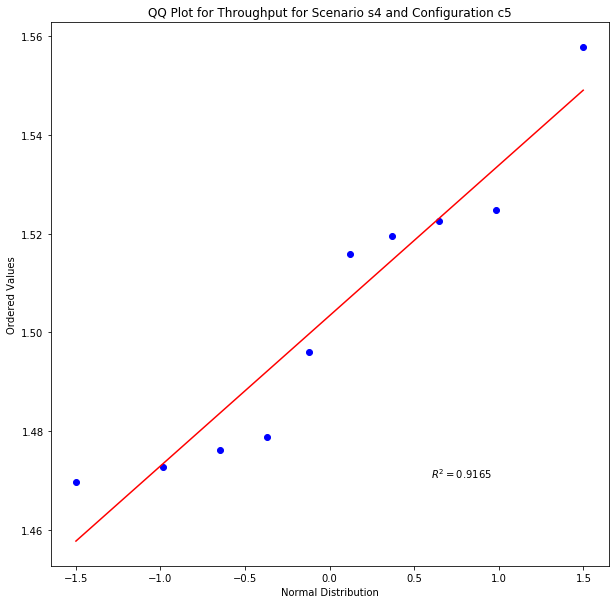

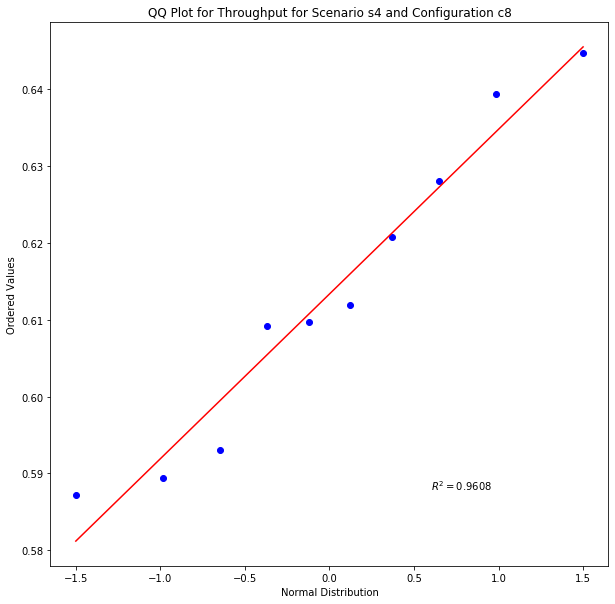

In [35]:
#Set here number of clients
numClients=49

for scenario in scenarios:
   
    for index,conf in enumerate(configurations):
        
        #Set the dimensions of the plot
        plt.figure(figsize=(10,10))

        repThroughput=dfThroughput.loc[(dfThroughput['scenario']==scenario)& (dfThroughput['config']==conf)&(dfThroughput['clients']==numClients)]['throughput']
        qqPlot = stats.probplot(list(repThroughput), dist='norm',plot=plt,rvalue=True)
        plt.title("QQ Plot for Throughput for Scenario "+scenario+" and Configuration "+conf)
        plt.xlabel("Normal Distribution")


# Response Time

In [29]:
#RENSPONSE TIME

#QUERY DB
dfResponseTime=pd.read_sql_query("""
SELECT clients, scenario, config,attrValue,statMean as responseTime 
from runConfig rc inner join statistic s on rc.runId = s.runId
        inner join runAttr ra on s.runId = ra.runId
WHERE 
		statName = "responseTimeStat:stats" AND
		moduleName = "Network"
        AND attrName = "repetition"
ORDER BY scenario, config, clients, attrValue
""", con)

dfResponseTime.head(100)

#dfResponseTime=dfResponseTime.loc[(dfResponseTime['attrValue']== '0')]
#dfResponseTime.drop(['attrValue'],axis=1)


,clients,scenario,config,attrValue,responseTime
0,1,s1,c1,0,0.480001
1,1,s1,c1,1,0.496964
2,1,s1,c1,2,0.486095
3,1,s1,c1,3,0.481619
4,1,s1,c1,4,0.489958
...,...,...,...,...,...
95,19,s1,c1,5,1.946410
96,19,s1,c1,6,1.972815
97,19,s1,c1,7,1.972806
98,19,s1,c1,8,1.949385


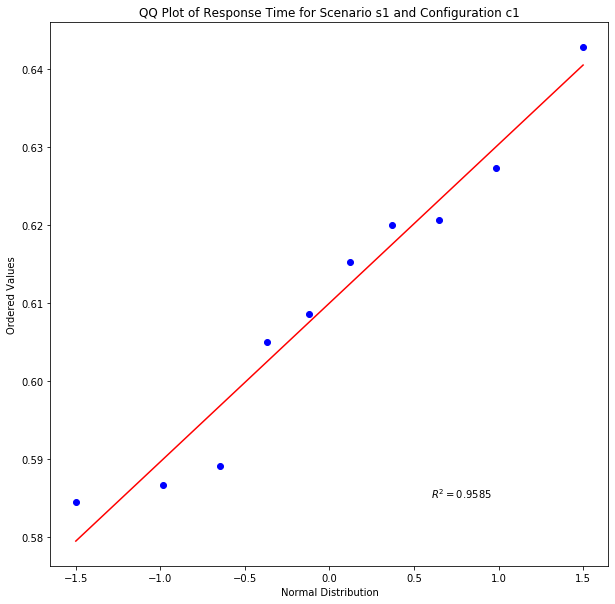

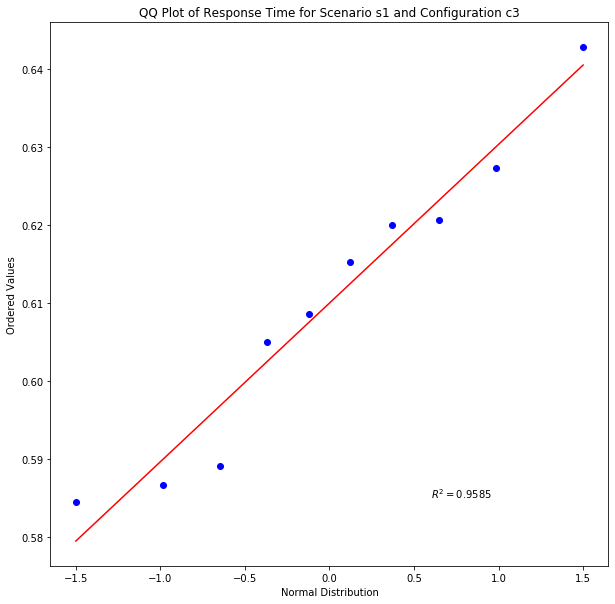

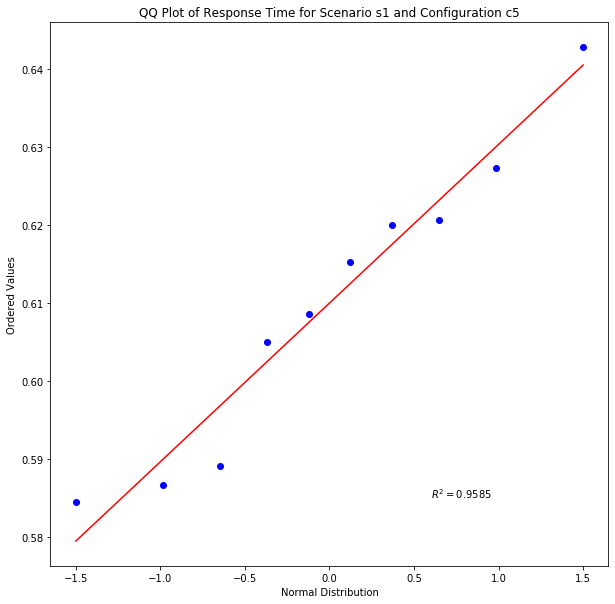

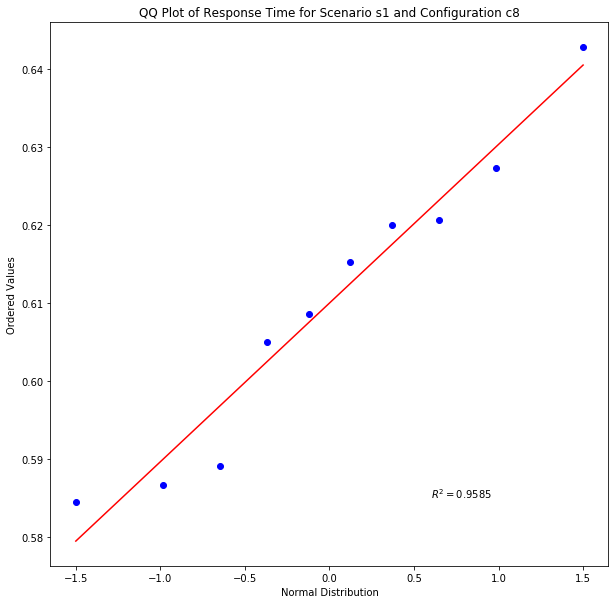

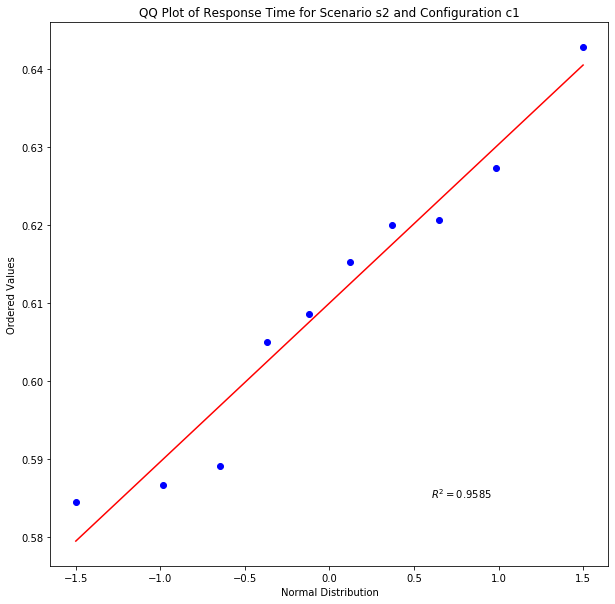

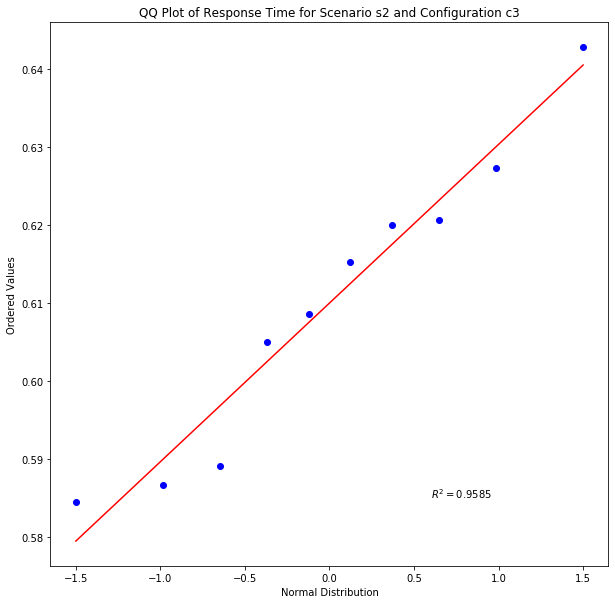

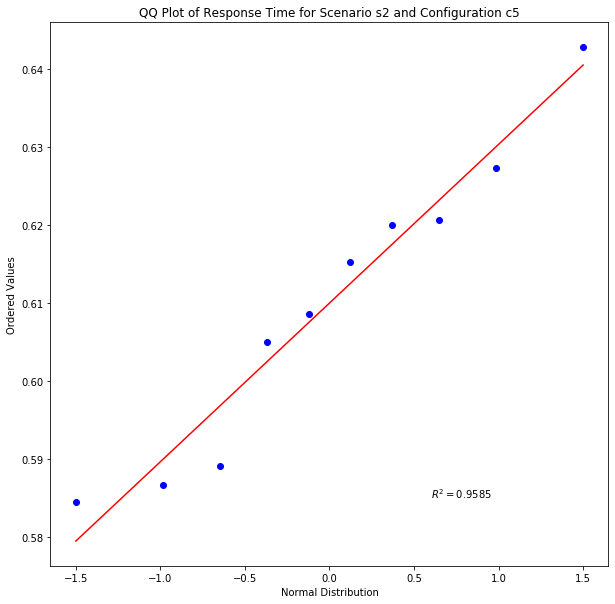

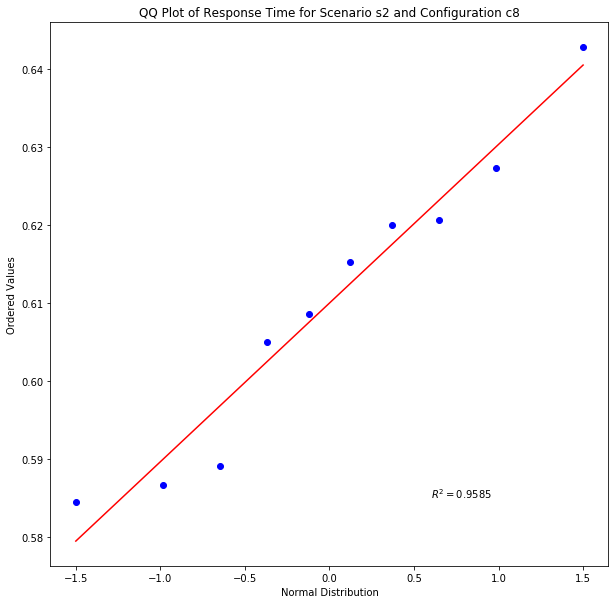

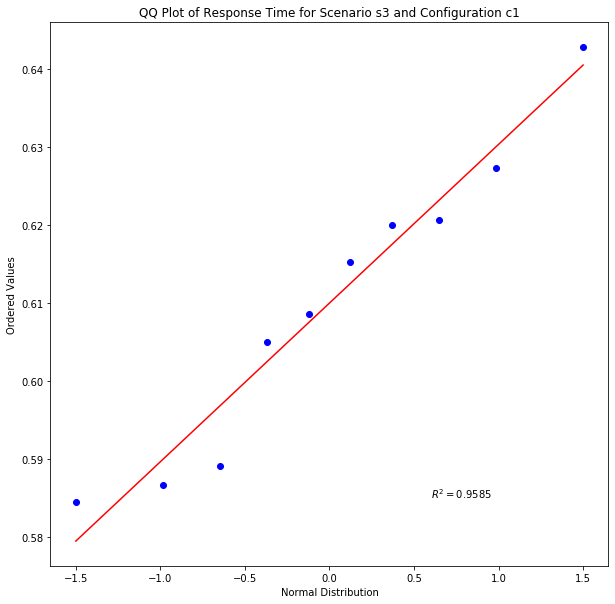

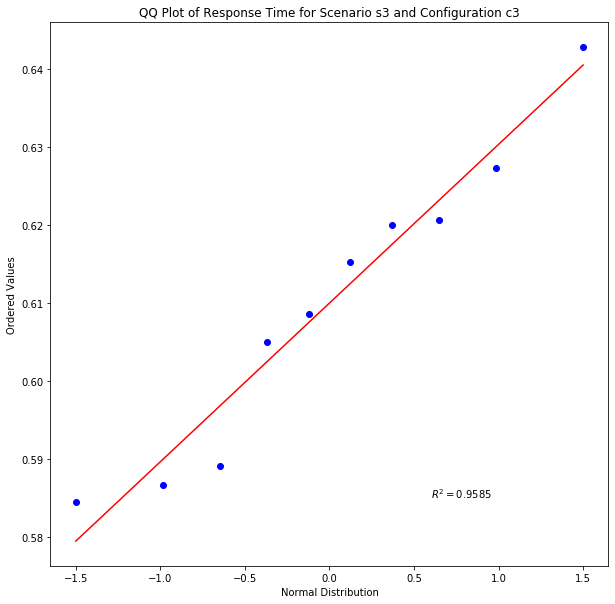

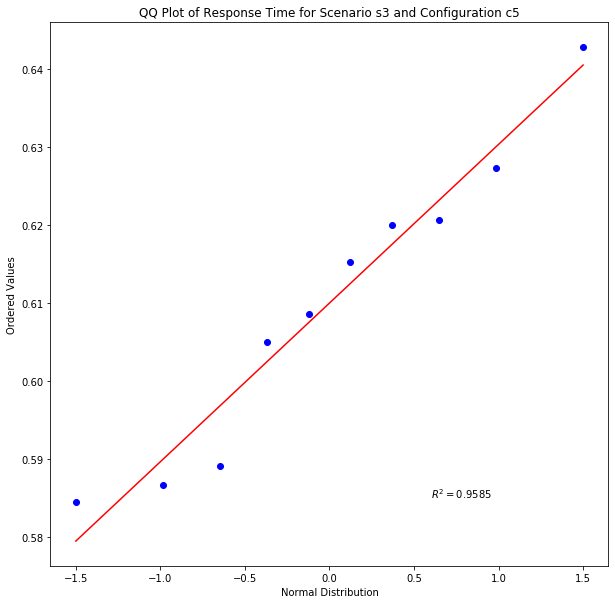

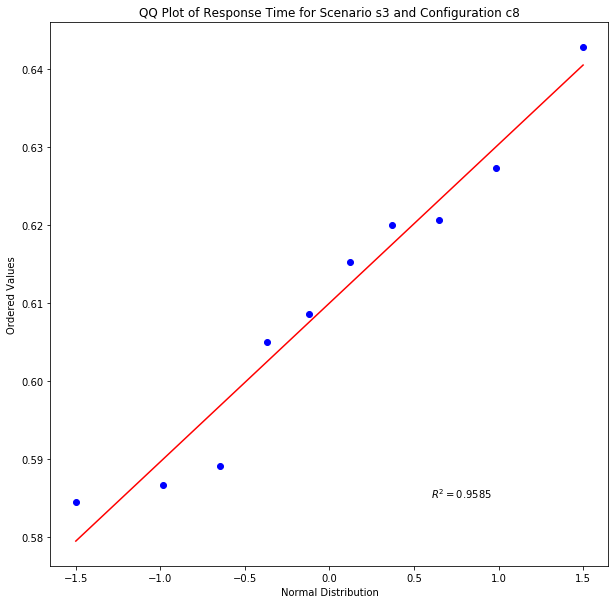

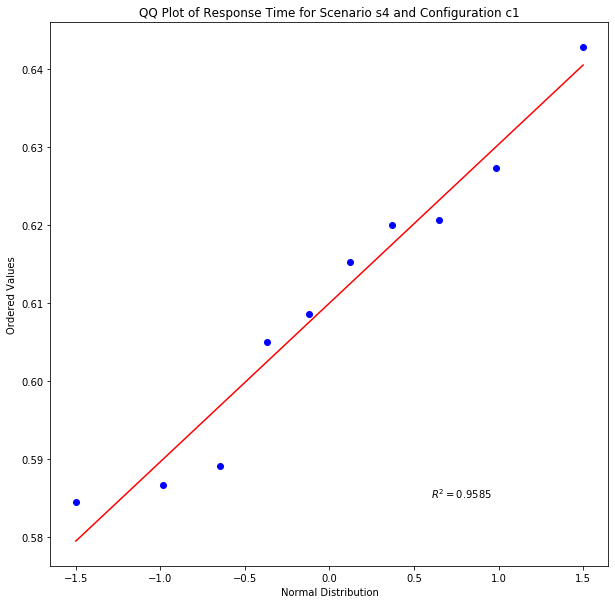

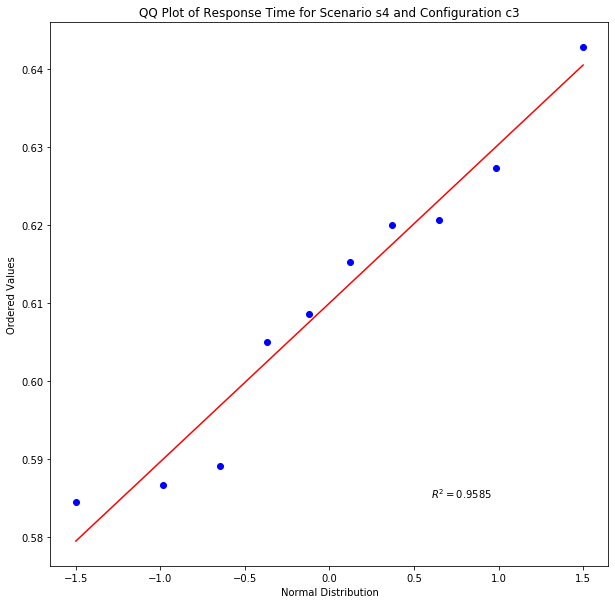

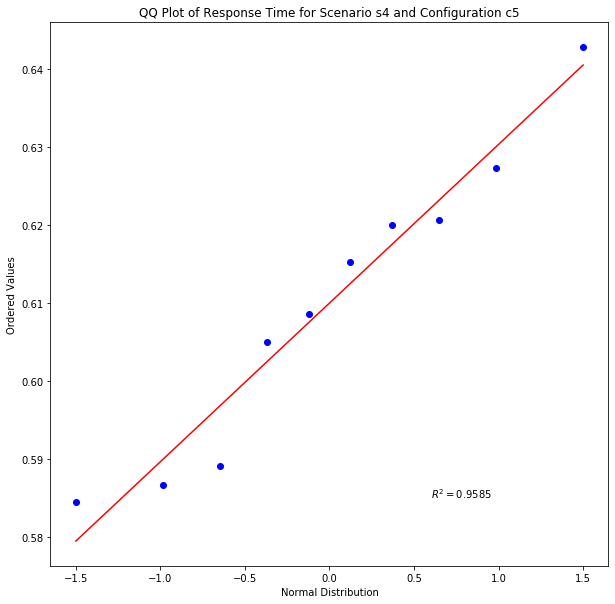

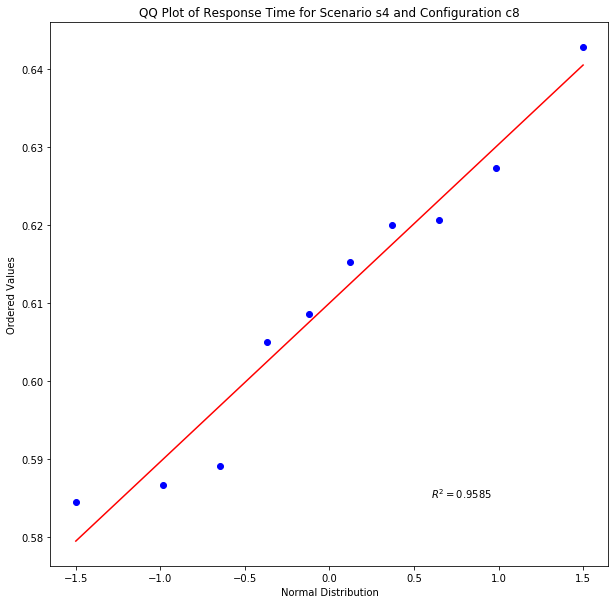

In [33]:
#Set here number of clients
numClients=29

for scenario in scenarios:
   
    for index,conf in enumerate(configurations):
        
        #Set the dimensions of the plot
        plt.figure(figsize=(10,10))

        repResponsetime=dfResponseTime.loc[(dfThroughput['scenario']==scenario)& (dfResponseTime['config']==conf)&(dfResponseTime['clients']==numClients)]['responseTime']
        qqPlot = stats.probplot(list(repThroughput), dist='norm',plot=plt,rvalue=True)
        plt.title("QQ Plot of Response Time for Scenario "+scenario+" and Configuration "+conf)
        plt.xlabel("Normal Distribution")


In [7]:
con.close()